# Predicting Heart Disease

## Score: .95360

In [27]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

DATA_DIR = Path("playground-series-s6e2")
OUTPUT_DIR = Path(".")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [28]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
train.head()

Train: (630000, 15)
Test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [29]:
target_col = "Heart Disease"
id_col = "id"
feature_cols = [c for c in train.columns if c not in (id_col, target_col)]

le = LabelEncoder()
y = le.fit_transform(train[target_col])

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

for col in feature_cols:
    if X_train[col].isna().any() or X_test[col].isna().any():
        med = X_train[col].median()
        X_train[col] = X_train[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

X_train["chol_exercise"] = X_train["Cholesterol"] * X_train["Exercise angina"]
X_test["chol_exercise"] = X_test["Cholesterol"] * X_test["Exercise angina"]

print(f"Features: {len(X_train.columns)} columns")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

Features: 14 columns
Target distribution: {0: 347546, 1: 282454}


In [30]:
param_grid = {
    "max_depth": [4, 5, 6],
    "learning_rate": [0.03, 0.05],
    "min_child_weight": [2, 3, 5],
}
best_auc = 0
best_params = None
for max_depth in param_grid["max_depth"]:
    for learning_rate in param_grid["learning_rate"]:
        for min_child_weight in param_grid["min_child_weight"]:
            model = xgb.XGBClassifier(
                n_estimators=1000,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                learning_rate=learning_rate,
                subsample=0.7,
                colsample_bytree=0.7,
                random_state=42,
                eval_metric="auc",
            )
            oof = cross_val_predict(model, X_train, y, cv=cv, method="predict_proba")[:, 1]
            auc = roc_auc_score(y, oof)
            if auc > best_auc:
                best_auc = auc
                best_params = {"max_depth": max_depth, "learning_rate": learning_rate, "min_child_weight": min_child_weight}
print(f"Best XGB CV AUC: {best_auc:.5f}")
print(f"Best params: {best_params}")

Best XGB CV AUC: 0.95542
Best params: {'max_depth': 4, 'learning_rate': 0.05, 'min_child_weight': 5}


In [31]:
oof_xgb = cross_val_predict(
    xgb.XGBClassifier(n_estimators=1000, **best_params, subsample=0.7, colsample_bytree=0.7, random_state=42, eval_metric="auc"),
    X_train, y, cv=cv, method="predict_proba",
)[:, 1]
oof_lgb = cross_val_predict(
    lgb.LGBMClassifier(n_estimators=1000, max_depth=best_params["max_depth"], min_child_samples=20, learning_rate=best_params["learning_rate"], subsample=0.7, colsample_bytree=0.7, random_state=42, verbosity=-1),
    X_train, y, cv=cv, method="predict_proba",
)[:, 1]
oof_cb = cross_val_predict(
    cb.CatBoostClassifier(iterations=1000, depth=best_params["max_depth"], min_data_in_leaf=20, learning_rate=best_params["learning_rate"], subsample=0.7, colsample_bylevel=0.7, random_seed=42, verbose=0),
    X_train, y, cv=cv, method="predict_proba",
)[:, 1]

meta_X = np.column_stack([oof_xgb, oof_lgb, oof_cb])
meta = LogisticRegression(C=0.1, max_iter=500, random_state=42)
meta.fit(meta_X, y)
oof_stack = meta.predict_proba(meta_X)[:, 1]
stack_auc = roc_auc_score(y, oof_stack)
print(f"Stack CV AUC: {stack_auc:.5f}")

best_blend_auc = 0
best_weights = None
for w_xgb in np.arange(0.2, 0.81, 0.1):
    for w_lgb in np.arange(0.1, 0.71, 0.1):
        w_cb = 1 - w_xgb - w_lgb
        if w_cb < 0:
            continue
        oof_blend = w_xgb * oof_xgb + w_lgb * oof_lgb + w_cb * oof_cb
        auc = roc_auc_score(y, oof_blend)
        if auc > best_blend_auc:
            best_blend_auc = auc
            best_weights = (w_xgb, w_lgb, w_cb)
print(f"Blend CV AUC: {best_blend_auc:.5f}, weights: {best_weights}")

best_alpha = 0.5
best_hybrid_auc = 0
for alpha in [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]:
    oof_hybrid = alpha * oof_stack + (1 - alpha) * (best_weights[0] * oof_xgb + best_weights[1] * oof_lgb + best_weights[2] * oof_cb)
    auc = roc_auc_score(y, oof_hybrid)
    if auc > best_hybrid_auc:
        best_hybrid_auc = auc
        best_alpha = alpha
print(f"Hybrid (stack + blend) CV AUC: {best_hybrid_auc:.5f}, best_alpha: {best_alpha}")

Stack CV AUC: 0.95543
Blend CV AUC: 0.95548, weights: (np.float64(0.30000000000000004), np.float64(0.30000000000000004), np.float64(0.3999999999999999))
Hybrid (stack + blend) CV AUC: 0.95548, best_alpha: 0


In [32]:
xgb_list = []
for seed in [42, 43, 44, 45, 46]:
    m = xgb.XGBClassifier(n_estimators=1000, **best_params, subsample=0.7, colsample_bytree=0.7, random_state=seed, eval_metric="auc")
    m.fit(X_train, y)
    xgb_list.append(m.predict_proba(X_test)[:, 1])
lgb_list = []
for seed in [42, 43, 44]:
    m = lgb.LGBMClassifier(n_estimators=1000, max_depth=best_params["max_depth"], min_child_samples=20, learning_rate=best_params["learning_rate"], subsample=0.7, colsample_bytree=0.7, random_state=seed, verbosity=-1)
    m.fit(X_train, y)
    lgb_list.append(m.predict_proba(X_test)[:, 1])
cb_list = []
for seed in [42, 43, 44]:
    m = cb.CatBoostClassifier(iterations=1000, depth=best_params["max_depth"], min_data_in_leaf=20, learning_rate=best_params["learning_rate"], subsample=0.7, colsample_bylevel=0.7, random_seed=seed, verbose=0)
    m.fit(X_train, y)
    cb_list.append(m.predict_proba(X_test)[:, 1])
w_xgb, w_lgb, w_cb = best_weights
xgb_avg = np.mean(xgb_list, axis=0)
lgb_avg = np.mean(lgb_list, axis=0)
cb_avg = np.mean(cb_list, axis=0)
test_meta_X = np.column_stack([xgb_avg, lgb_avg, cb_avg])
test_proba_stack = meta.predict_proba(test_meta_X)[:, 1]
test_proba_blend = w_xgb * xgb_avg + w_lgb * lgb_avg + w_cb * cb_avg
test_proba = best_alpha * test_proba_stack + (1 - best_alpha) * test_proba_blend

Confusion matrix (OOF hybrid, threshold=0.5)
Rows: true, Cols: predicted |  Absence   Presence
[[315075  32471]
 [ 37520 244934]]


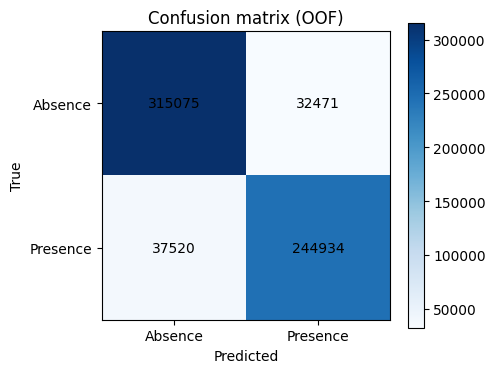

In [33]:
oof_blend = best_weights[0] * oof_xgb + best_weights[1] * oof_lgb + best_weights[2] * oof_cb
oof_hybrid = best_alpha * oof_stack + (1 - best_alpha) * oof_blend
y_pred = (oof_hybrid >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)
print("Confusion matrix (OOF hybrid, threshold=0.5)")
print("Rows: true, Cols: predicted |  Absence   Presence")
print(cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Absence", "Presence"])
plt.yticks([0, 1], ["Absence", "Presence"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.title("Confusion matrix (OOF)")
plt.tight_layout()
plt.show()

In [34]:
sub = pd.DataFrame({"id": test["id"], "Heart Disease": test_proba})
sub.to_csv(OUTPUT_DIR / "submission.csv", index=False)
print(f"Submission saved to {OUTPUT_DIR / 'submission.csv'}")
sub.head(10)

Submission saved to submission.csv


,id,Heart Disease
0,630000,0.956431
1,630001,0.008228
2,630002,0.987967
3,630003,0.005026
4,630004,0.192525
5,630005,0.983172
6,630006,0.004443
7,630007,0.628030
8,630008,0.992603
9,630009,0.013430
